# Modeling
## Initial Steps
First let's open our train dataset.

In [201]:
import matplotlib.pyplot as plt
import pandas as pd

x_test_df = pd.read_csv('./test.csv').drop(['status'], axis=1)
_train_df = pd.read_csv('./train.csv')
_train_df.head()

,loan_id,account_id,loan_date,loan_amount,duration,payments,status,birth_number,district_id,gender,...,trans_type_std_withdrawal,trans_type_std_credit,days_last_trans,last_balance_l,max_balance_l,age_months,bal_per_month,trans_per_month,owner_age_at,account_age
0,4959,-5.199338,-1.543098,-0.430727,-0.530220,-0.216904,1,-0.952023,-5.199338,5.199338,...,0.063341,0.063341,0.178175,0.111650,0.236579,-0.249863,-0.187886,-0.268923,0.816627,-0.269066
1,4961,-3.034250,0.604585,-1.335178,-5.199338,-0.622082,-1,-1.619856,-0.458679,-5.199338,...,0.321971,0.321971,2.455101,0.544529,1.112094,0.049948,-0.808732,0.553766,1.807354,0.114185
2,4973,-2.603792,0.619855,0.356532,-0.530220,1.075550,1,-1.024053,-0.604585,-5.199338,...,-1.119968,-1.119968,-0.781781,-0.935819,-0.112402,1.029957,-0.425841,0.651081,1.029957,1.029957
3,4996,-2.356668,1.544916,-0.301747,-5.199338,1.367558,1,-0.902159,0.012660,-5.199338,...,1.399657,1.399657,0.403108,0.925573,0.516890,-1.025023,1.439869,-0.166433,1.029957,-1.021681
4,5002,-2.272299,-1.006949,-0.067424,-5.199338,2.301079,1,-1.496373,0.987837,5.199338,...,-0.048867,-0.048867,0.403108,-0.213490,-0.265617,-0.987837,0.381108,-0.544847,1.399657,-0.979545


Most prediction and scoring algorithms in scikit-learn require the positive class to have label 1 and the negative class to have label 0 so we are going to change the values in the status, given that the positive class is labeled -1 in the train dataset.

In [202]:
_train_df['status'].value_counts()

 1    282
-1     46
Name: status, dtype: int64

In [203]:
_train_df.loc[_train_df['status'] == 1, 'status'] = 2
_train_df.loc[_train_df['status'] == -1, 'status'] = 1
_train_df.loc[_train_df['status'] == 2, 'status'] = 0

In [204]:
_train_df['status'].value_counts()

0    282
1     46
Name: status, dtype: int64

## Solving Class Imbalance
As we can see, the number of rows labeled with the positive class (46) is much smaller than the number of rows labeled with the negative class (282) so we are going to use SMOTE to balance the classes.

In [205]:
from imblearn.over_sampling import SMOTE

x_train_df = _train_df.drop(['status'], axis=1)
y_train_df = _train_df['status']

sm = SMOTE(random_state=42)
x_train_df, y_train_df = sm.fit_resample(x_train_df, y_train_df)

## Model Selection

In this section we are going to select a model using ``GridSearchCV``, a feature of scikit-learn which tunes hyperparameters, that is, it exhaustively searches over specified parameter values for an estimator and returns the best estimator according to a metric or metrics of our choice. In this case, we are going to measure the quality of the estimator using the F1, accuracy measures and area under the ROC curve. The ``GridSearchCV`` is configured to use cross validation with ``StratifiedKFold`` to better evaluate the quality of the estimator and returns the estimator with the best AUC or the best F1 score where it is a more relevant score.

The best model in the training phase was Logistic Regression with a AUC score of 0.968. The same model, in the testing phase, scored 0.943 in the public leaderboard and 0.851 in the private leaderboard. The Multi-layer Perceptron Classifier was the best classifier for the private leaderboard with a score of 0.858 and a public leaderboard score of 0.918. Despite being slightly worse than the Logistic Regression model in the public leaderboard, it is also slightly better in the private leaderboard.

The Gaussian Naive Bayes Classifier came in third place at 0.771 in the private leaderboard. The other two algorithms, C-Support Vector Classification and K-Nearest Neighbors performed very poorly having an AUC score of 0.451 and 0.522 respectively in the private leaderboard.

In [245]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

### Using Logistic Regression (Maximum Entropy Classifier)


In [247]:
from sklearn.linear_model import LogisticRegression
params = {
    'class_weight': [{0: 1, 1: v} for v in range(1, 10)],
    'C': [20.0, 10.0, 1.0],
    'penalty': ['l2', 'none']
}

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000000),
    param_grid=params,
    scoring={'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 'auc': make_scorer(roc_auc_score)},
    refit='auc',
    cv=4,
    n_jobs=-1 # enable parallelism
)

grid.fit(x_train_df, y_train_df)

c:\Users\gonca\FEUP-CAC\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000000), n_jobs=-1,
             param_grid={'C': [20.0, 10.0, 1.0],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}, {0: 1, 1: 4},
                                          {0: 1, 1: 5}, {0: 1, 1: 6},
                                          {0: 1, 1: 7}, {0: 1, 1: 8},
                                          {0: 1, 1: 9}],
                         'penalty': ['l2', 'none']},
             refit='auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [248]:
grid.best_estimator_

LogisticRegression(C=20.0, class_weight={0: 1, 1: 8}, max_iter=1000000,
                   penalty='none')

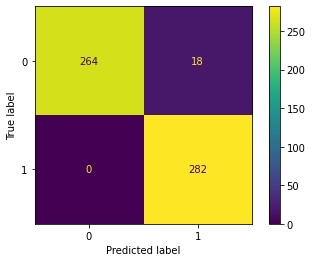

In [249]:
predicted = grid.predict(x_train_df)
disp = ConfusionMatrixDisplay.from_predictions(y_train_df, predicted)

In [250]:
print(f'F1 Score {f1_score(y_train_df, predicted)}\nAccuracy Score: {accuracy_score(y_train_df, predicted)}\nArea under the ROC curve: {roc_auc_score(y_train_df, predicted)}')
print(f'Precision: {precision_score(y_train_df, predicted)}\nRecall: {recall_score(y_train_df, predicted)}')

F1 Score 0.9690721649484536
Accuracy Score: 0.9680851063829787
Area under the ROC curve: 0.9680851063829787
Precision: 0.94
Recall: 1.0


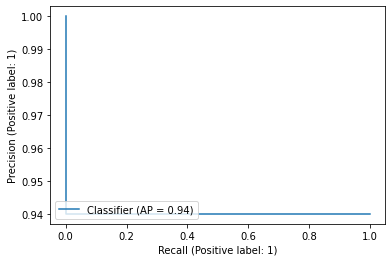

In [211]:
disp = PrecisionRecallDisplay.from_predictions(y_train_df, predicted)

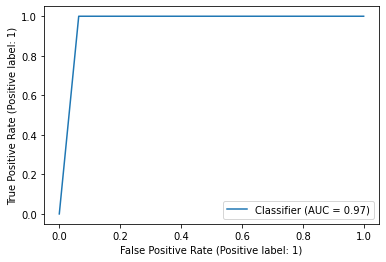

In [212]:
disp = RocCurveDisplay.from_predictions(y_train_df, predicted)

In [213]:
results = {
    'Id': x_test_df['loan_id'],
    'Predicted': grid.predict_proba(x_test_df)[:, 1]
}

pd.DataFrame(results).to_csv('submission-lr.csv', index=False)

### Using KNearestNeighbors Classifier

In [214]:
from sklearn.neighbors import KNeighborsClassifier
params = {
    'n_neighbors': [i for i in range(1, 385)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    scoring={'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 'auc': make_scorer(roc_auc_score)},
    refit='f1',
    cv=4,
    n_jobs=-1 # enable parallelism
)

grid.fit(x_train_df, y_train_df)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [215]:
grid.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

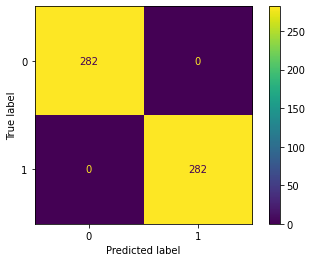

In [216]:
predicted = grid.predict(x_train_df)
disp = ConfusionMatrixDisplay.from_predictions(y_train_df, predicted)

In [217]:
print(f'F1 Score {f1_score(y_train_df, predicted)}\nAccuracy Score: {accuracy_score(y_train_df, predicted)}\nArea under the ROC curve: {roc_auc_score(y_train_df, predicted)}')
print(f'Precision: {precision_score(y_train_df, predicted)}\nRecall: {recall_score(y_train_df, predicted)}')

F1 Score 1.0
Accuracy Score: 1.0
Area under the ROC curve: 1.0
Precision: 1.0
Recall: 1.0


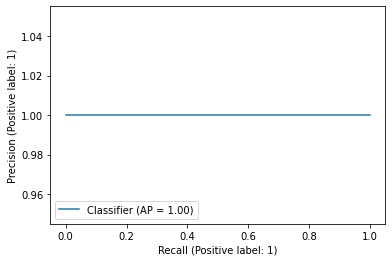

In [218]:
disp = PrecisionRecallDisplay.from_predictions(y_train_df, predicted)

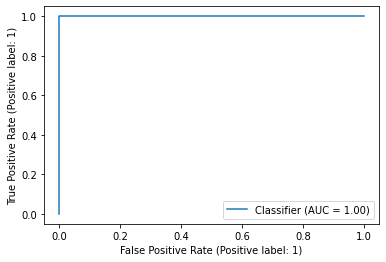

In [219]:
disp = RocCurveDisplay.from_predictions(y_train_df, predicted)

In [220]:
results = {
    'Id': x_test_df['loan_id'],
    'Predicted': grid.predict_proba(x_test_df)[:, 1]
}

pd.DataFrame(results).to_csv('submission-knn.csv', index=False)

### Using MLPClassifier (Multi-layer Perceptron)

In [221]:
from sklearn.neural_network import MLPClassifier
params = {
    'hidden_layer_sizes': [(64,), (32,)],
    'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 1e-6],
    'batch_size': ['auto', 64],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

grid = GridSearchCV(
    estimator=MLPClassifier(max_iter=100000, random_state=42),
    param_grid=params,
    scoring={'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 'auc': make_scorer(roc_auc_score)},
    refit='auc',
    cv=4,
    n_jobs=-1 # enable parallelism
)

grid.fit(x_train_df, y_train_df)

GridSearchCV(cv=4, estimator=MLPClassifier(max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
                         'batch_size': ['auto', 64],
                         'hidden_layer_sizes': [(64,), (32,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             refit='auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [222]:
grid.best_estimator_

MLPClassifier(activation='logistic', alpha=0.01, batch_size=64,
              hidden_layer_sizes=(64,), max_iter=100000, random_state=42)

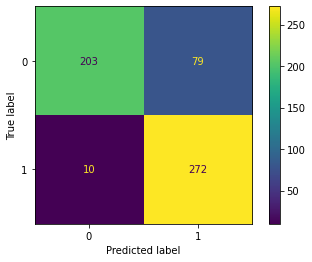

In [223]:
predicted = grid.predict(x_train_df)
disp = ConfusionMatrixDisplay.from_predictions(y_train_df, predicted)

In [224]:
print(f'F1 Score {f1_score(y_train_df, predicted)}\nAccuracy Score: {accuracy_score(y_train_df, predicted)}\nArea under the ROC curve: {roc_auc_score(y_train_df, predicted)}')
print(f'Precision: {precision_score(y_train_df, predicted)}\nRecall: {recall_score(y_train_df, predicted)}')

F1 Score 0.8593996840442338
Accuracy Score: 0.8421985815602837
Area under the ROC curve: 0.8421985815602837
Precision: 0.7749287749287749
Recall: 0.9645390070921985


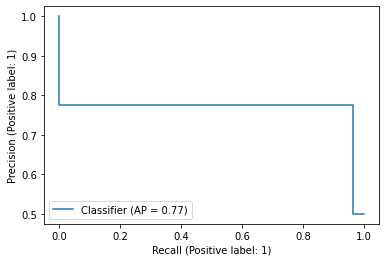

In [225]:
disp = PrecisionRecallDisplay.from_predictions(y_train_df, predicted)

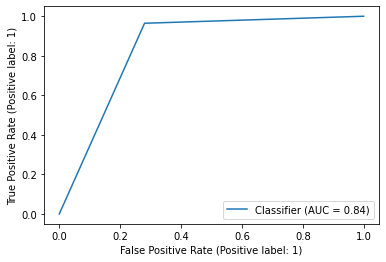

In [226]:
disp = RocCurveDisplay.from_predictions(y_train_df, predicted)

In [227]:
results = {
    'Id': x_test_df['loan_id'],
    'Predicted': grid.predict_proba(x_test_df)[:, 1]
}

pd.DataFrame(results).to_csv('submission-mlp.csv', index=False)

### Using SVC (C-Support Vector Classification)

In [228]:
from sklearn.svm import SVC
params = {
  'C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001], 
  'class_weight': [{0: 1, 1: v} for v in range(1, 10)],
  'gamma': ['scale', 'auto'],
  'tol': [1.0, 1e-3, 1e-6],
  'break_ties': [True, False]
}

grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=params,
    scoring={'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 'auc': make_scorer(roc_auc_score)},
    refit='f1',
    cv=4,
    n_jobs=-1 # enable parallelism
)

grid.fit(x_train_df, y_train_df)

GridSearchCV(cv=4, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
                         'break_ties': [True, False],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}, {0: 1, 1: 4},
                                          {0: 1, 1: 5}, {0: 1, 1: 6},
                                          {0: 1, 1: 7}, {0: 1, 1: 8},
                                          {0: 1, 1: 9}],
                         'gamma': ['scale', 'auto'],
                         'tol': [1.0, 0.001, 1e-06]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [229]:
grid.best_estimator_

SVC(break_ties=True, class_weight={0: 1, 1: 2}, gamma='auto', probability=True,
    random_state=42)

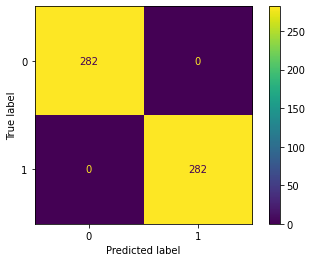

In [230]:
predicted = grid.predict(x_train_df)
disp = ConfusionMatrixDisplay.from_predictions(y_train_df, predicted)

In [231]:
print(f'F1 Score: {f1_score(y_train_df, predicted)}\nAccuracy Score: {accuracy_score(y_train_df, predicted)}\nArea under the ROC curve: {roc_auc_score(y_train_df, predicted)}')
print(f'Precision: {precision_score(y_train_df, predicted)}\nRecall: {recall_score(y_train_df, predicted)}')

F1 Score: 1.0
Accuracy Score: 1.0
Area under the ROC curve: 1.0
Precision: 1.0
Recall: 1.0


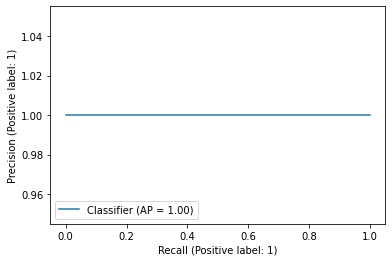

In [232]:
disp = PrecisionRecallDisplay.from_predictions(y_train_df, predicted)

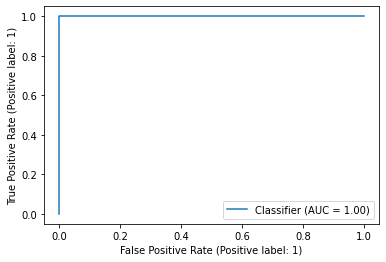

In [233]:
disp = RocCurveDisplay.from_predictions(y_train_df, predicted)

In [234]:
results = {
    'Id': x_test_df['loan_id'],
    'Predicted': grid.predict_proba(x_test_df)[:, 1]
}

pd.DataFrame(results).to_csv('submission-svc.csv', index=False)

### Using GaussianNaiveBayes Classifier

In [235]:
from sklearn.naive_bayes import GaussianNB
params = {
    'priors': [[0.5, 0.5], [0.3, 0.7], [0.2, 0.8], [0.7, 0.3], [0.8, 0.2], [0.9999, 0.0001]]
}

grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=params,
    scoring={'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score), 'auc': make_scorer(roc_auc_score)},
    refit='auc',
    cv=4,
    n_jobs=-1 # enable parallelism
)

grid.fit(x_train_df, y_train_df)

GridSearchCV(cv=4, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'priors': [[0.5, 0.5], [0.3, 0.7], [0.2, 0.8],
                                    [0.7, 0.3], [0.8, 0.2], [0.9999, 0.0001]]},
             refit='auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
                      'f1': make_scorer(f1_score)})

In [239]:
grid.best_estimator_

GaussianNB(priors=[0.9999, 0.0001])

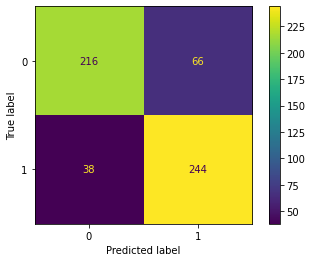

In [240]:
predicted = grid.predict(x_train_df)
disp = ConfusionMatrixDisplay.from_predictions(y_train_df, predicted)

In [241]:
print(f'F1 Score: {f1_score(y_train_df, predicted)}\nAccuracy Score: {accuracy_score(y_train_df, predicted)}\nArea under the ROC curve: {roc_auc_score(y_train_df, predicted)}')
print(f'Precision: {precision_score(y_train_df, predicted)}\nRecall: {recall_score(y_train_df, predicted)}')

F1 Score: 0.8243243243243243
Accuracy Score: 0.8156028368794326
Area under the ROC curve: 0.8156028368794327
Precision: 0.7870967741935484
Recall: 0.8652482269503546


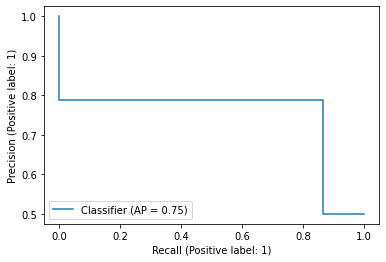

In [242]:
disp = PrecisionRecallDisplay.from_predictions(y_train_df, predicted)

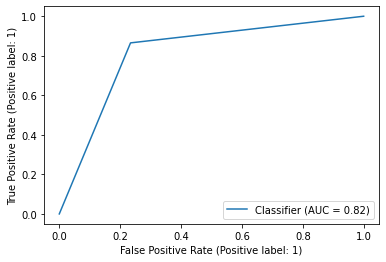

In [243]:
disp = RocCurveDisplay.from_predictions(y_train_df, predicted)

In [244]:
results = {
    'Id': x_test_df['loan_id'],
    'Predicted': grid.predict_proba(x_test_df)[:, 1]
}

pd.DataFrame(results).to_csv('submission-nb.csv', index=False)